# Project 1: Ranked-choice voting systems [40 marks]

In this project, you will write Python functions to tally election results from a set of ballots submitted by voters, using different vote counting systems.

You will write all your code as function definitions, in one of 3 modules: `ballot_data.py`, `pos.py`, `irv.py`, or `stv.py`. The second part of the Week 6 Monday lecture covers writing and using modules.

- Each module should **only contain function definitions, and any required `import` statements** (for example if you need to import `numpy`).
- For each question, a few simple **tests** will be provided in the notebook. You can use these to start checking that your function works as expected. They work similarly to your Coderunner quizzes.
    - In some cases, the tests use `assert` statements (or similar functions from [`np.testing`](https://numpy.org/doc/stable/reference/routines.testing.html)).
        - `assert X` will do nothing if `X` is `True`.
        - `assert X` will produce an `AssertionError` if `X` is `False`.
    - The provided tests are minimal (similar to the "Examples" provided for pre-checking in the Coderunner quizzes). To make sure that your function works fully with all possible inputs, you should add more of your own tests.
    - Any tests that you write yourself will not be assessed.
    - Some of the tests load a small amount of ballot data from a `.txt` file. You can look at the data itself by looking at the content of the files.
    - When you submit on Gradescope, more automatic tests will be performed. You will see the results of **some** of these tests when you submit; if any fail, you can try to correct your code, and resubmit as many times as you want (until the deadline).
    - Gradescope will also have hidden tests which will test your functions further (similar to the further tests in the Coderunner quizzes, which are run when you click "Check"). You will not see the results of these tests until the grades and feedback are returned to the class. This means, in particular, that *passing all the visible tests on Gradescope does not guarantee full marks.*
- **Up to half** of the marks for a given question may be deducted for poor readability; missing, incomplete, or inaccurate code comments and/or docstrings; poor code structure and efficiency; or poorly displayed results. You can use the CR marking scheme for reference to make sure you submit good-quality code.

In [1]:
# Run this cell to import modules
import ballot_data as bd, pos, irv, stv
import numpy as np
import importlib

---

## Ranked-choice voting

To experiment with different counting systems, we first need some ballots to count. In all cases for this project, a number of voters have been asked to fill their ballots by **ranking their favourite candidates in order of preference**; this is called _ranked-choice voting_.

For ease of reference, we will index voters and candidates from 0, meaning that e.g. the first candidate on the ballot will be referred to as "Candidate 0".

For example, with 5 candidates, one filled ballot might look like this:

<div>
<img src="img/ballot.png" width="250px" alt="Filled ballot example"/>
</div>

This voter has selected Candidate 2 as their favourite candidate, and ranked them as first preference. They then ranked Candidate 4 as their second preference, and Candidate 1 as their third preference. They chose not to rank any other candidate -- presumably they really dislike Candidates 0 and 3.

All ballots must have **at least one candidate ranked** as first preference to be valid, but each voter can choose to rank anywhere between 1 and all candidates, in order of preference. The voter in the example above chose to rank 3 candidates.

Different vote counting systems can be used to process the ballot data in different ways, which will lead to different results -- this depends largely on how second, third, etc. preferences are counted. This project will explore some of these systems.

## Ballot data representation

We choose to represent the ballot data using a rectangular NumPy array, where:

- each **row** represents **one ballot** submitted by one voter;
- each **column** represents the ranked preferences for **one candidate**;
- a value of `0` indicates no ranking.

For example, all the ballots for an election with 4 candidates and 10 voters might look like this:

```
[[1. 0. 0. 0.]
 [3. 2. 0. 1.]
 [0. 1. 2. 0.]
 [3. 2. 1. 4.]
 [1. 0. 2. 0.]
 [0. 0. 1. 2.]
 [0. 3. 2. 1.]
 [0. 0. 1. 0.]
 [4. 1. 3. 2.]
 [0. 1. 0. 0.]]
```

where, for example:

- row 0 showing `[1. 0. 0. 0.]` means that Voter 0 has ranked Candidate 0 as their first preference, and chosen not to rank any other candidates;
- row 1 showing `[3. 2. 0. 1.]` means that Voter 1 has ranked Candidate 3 as their first preference, Candidate 1 as their second preference, and Candidate 0 as their third preference;
- etc.

The function `generate_ballots()` is provided in `ballot_data.py` to generate random ballots for a given number of voters and candidates, and a target distribution of probabilities for each candidate to be ranked as a particular preference. You should not modify it -- it's provided for your information, and you should feel free to use it to generate datasets for testing your functions throughout the assignment.

## Tallying preferences

Before we start calculating election results, we need to be able to tally the total voter preferences allocated to a given candidate, at a given rank.

In `ballot_data.py`, you are given a function `select_ballots()` which takes 3 input arguments:

- `ballots`, a NumPy array containing ballot data as explained above, with one row per ballot and one column per candidate,
- `rank`, an integer between 1 and the total number of candidates (inclusive),
- `candidate`, an integer between 0 and the total number of candidates minus 1 (inclusive), corresponding to a particular candidate,

and returns a NumPy vector with the same length as the number of rows in `ballots` (the number of voters), containing `True` where the corresponding ballots have ranked candidate `candidate` as their `rank`th preference, and `False` everywhere else.

Essentially, this function returns a mask or a stencil which will allow us to select only certain ballots we're interested in. For an example of this, review Exercise 3 in the Week 4 notebook; we can select certain parts of a NumPy array depending on a given condition.

For example, `selector = select_ballots(ballots, 2, 1)` returns a NumPy vector, whose `True` values correspond to all the rows of `ballots` where candidate 1 was ranked as 2nd preference. Here is an example with 4 candidates -- the **important feature** is that **candidate 1 is ranked as 2nd preference** in all ballots selected using `selector`. (The selected ballots are indicated with `->` for clarity.)


```
        ballots          selector       ballots[selector]
    
->  [[1. 2. 0. 0.]       [True           [[1. 2. 0. 0.]
     [0. 0. 1. 0.]        False           [0. 2. 1. 0.]
     [1. 0. 3. 2.]        False           [3. 2. 1. 0.]
     [0. 0. 0. 1.]        False           [0. 2. 0. 1.]]
     [1. 3. 4. 2.]        False
->   [0. 2. 1. 0.]        True
->   [3. 2. 1. 0.]        True
     [1. 4. 3. 2.]        False
->   [0. 2. 0. 1.]        True
     [0. 0. 1. 2.]]       False]
```

In [2]:
# Run this cell to test your function (don't change this code!)
importlib.reload(bd);                        # Refresh any changes made to ballot_data.py
ballots = np.loadtxt('testing/tally.txt')    # Load ballot data exactly as in the example above
selector = bd.select_ballots(ballots, 2, 1)  # Use the function to select the ballots

# This should correspond to the above
print(selector)
print(ballots[selector])

[ True False False False False  True  True False  True False]
[[1. 2. 0. 0.]
 [0. 2. 1. 0.]
 [3. 2. 1. 0.]
 [0. 2. 0. 1.]]


---

#### 🚩 Task 1 [3 marks]

In `ballot_data.py`, write a function `tally_preferences()` which takes 2 input arguments:

- `ballots`, a NumPy array containing ballot data, with one row per ballot and one column per candidate,
- `rank`, an integer between 1 and the total number of candidates (inclusive),

and returns `preferences`, a list or a NumPy vector of the same length as the total number of candidates, which contains the total number of preferences at the given `rank` for each candidate, from left to right.

For example, `tally_preferences(ballots, 1)` should count the number of 1st preferences given to each candidate. Using the same set of ballots as in the example above, the returned list or NumPy vector should be `[4, 0, 4, 2]`, since candidate 0 received 4 first preference votes; candidate 1 received 0 first preferences; etc.

In [3]:
# Run this cell to test your function (don't change this code!)
importlib.reload(bd);
ballots = np.loadtxt('testing/tally.txt')

# Number of first preferences
preferences = bd.tally_preferences(ballots, 1)
np.testing.assert_equal(preferences, [4, 0, 4, 2])

# Number of third preferences
preferences = bd.tally_preferences(ballots, 3)
np.testing.assert_equal(preferences, [1, 1, 2, 0])

print('Passed the tests.')

Passed the tests.


---

## Electing a candidate

Now that we have a way to tally preferences for all candidates at any rank, we can proceed to electing a candidate. There exist many different ways to count votes and elect a candidate from ranked-choice ballots; we will implement some of these.

---

***Note:*** when writing functions for the rest of the assignment, in `pos.py` and in `irv.py`, you will need to use your functions `select_ballots()` and `tally_preferences()` from `ballot_data.py`.

You will see `import ballot_data as bd` at the top of `pos.py` and `irv.py`. **Don't change it**! With this statement, use `bd.select_ballots()` and `bd.tally_preferences()` whenever you need to use any of the functions from `ballot_data.py`, as is done in the notebook.

---

## Positional voting

In **positional voting**, the rank given to each candidate on the ballot is worth a certain weight, or a certain number of points (this is equivalent). Normally, higher-ranked preference votes are given more weight than lower-ranked preferences.

Here is an example: with 3 candidates, we could decide that

- first preferences are worth 3 points,
- second preferences are worth 2 points,
- third preferences are worth 1 point.

This means that a first-preference vote is worth 3 times the weight of a third-preference vote, for instance.

The votes are counted by tallying all the first, second, etc. preferences for each candidate, each time multiplying the count by the corresponding weight, and summing the total. For instance, if there are 7 ballots with ranked preferences for our 3 candidates:

```
[[0. 1. 0.]
 [1. 2. 3.]
 [1. 2. 0.]
 [1. 2. 3.]
 [3. 1. 2.]
 [0. 1. 0.]
 [1. 2. 0.]]
```

Counting the number of 1st, 2nd, and 3rd preferences for each candidate, we have:

| | Candidate 0 | Candidate 1 | Candidate 2 |
|:--:|:--:|:--:|:--:|
| 1st preferences (3 pts) | 4 | 3 | 0 |
| 2nd preferences (2 pts) | 0 | 4 | 1 |
| 3rd preferences (1 pt) | 1 | 0 | 2 |

Finally, counting the points:
- Candidate 0 gets $4\times 3 + 0 \times 2 + 1 \times 1 = 13$ points.
- Candidate 1 gets $3\times 3 + 4 \times 2 + 0 \times 1 = 17$ points.
- Candidate 2 gets $0\times 3 + 1 \times 2 + 2 \times 1 = 4$ points.

Candidate 1 is elected with 17 points.

The weights in this example are `[3, 2, 1]`, but this is not the only possible choice. For instance, some systems would use `[2, 1, 0]`; others use `[1, 1/2, 1/3]`; etc.

---

#### 🚩 Task 2 [5 marks]

In `pos.py`, write a function `positional_voting()` which takes 2 input arguments:

- `ballots`, a NumPy array containing ballot data, with one row per ballot and one column per candidate,
- `weights`, a list with the same length as the number of candidates, containing the weights attributed to each preference rank, in decreasing order (with the weight for the 1st preference given first, etc.),

and returns `results`, a list or NumPy vector with the same length as the number of candidates, containing the total number of points obtained by each candidate using the positional voting system with the weights given in `weights`.

For instance, using the example above, `positional_voting(ballots, [3, 2, 1])` should return `[13, 17, 4]`.

In [4]:
importlib.reload(pos);
ballots = np.array([[0, 1, 0],
                    [1, 2, 3],
                    [1, 2, 0],
                    [1, 2, 3],
                    [3, 1, 2],
                    [0, 1, 0],
                    [1, 2, 0]])

# Testing the proposed example
results = pos.positional_voting(ballots, [3, 2, 1])
np.testing.assert_equal(results, [13, 17, 4])

# Choosing weights to only count 3rd preferences
results = pos.positional_voting(ballots, [0, 0, 1])
np.testing.assert_equal(results, [1, 0, 2])

# k+1th preference is half the weight of kth preference
results = pos.positional_voting(ballots, [1, 1/2, 1/4])
np.testing.assert_equal(results, [4.25, 5, 1])

print('Passed the tests.')

Passed the tests.


---

#### 🚩 Task 3 [6 marks]

In `pos.py`, write a function `display_results()` which takes 2 input arguments:

- `ballots`, a NumPy array containing ballot data, with one row per ballot and one column per candidate,
- `weight_sets`, a **list of `N` lists** containing `N` different `weights` lists as defined in Task 2,

and generates a figure containing `N` subplots, stacked **vertically**.

- Each subplot should display a **bar chart**, with one bar indicating the overall score for each candidate, calculated with the positional voting method using a given set of weights.
- Each subplot should have some indication of what weights were used to calculate the results (e.g. in the title of the plot, or as an annotation).
- In each subplot, the winner of the election should be shown clearly. For example, you could display their bar in a different colour.
- Your function should work, and display the appropriate number of subplots, for any number of weight sets (for any $N \geq 1$).
- To calculate the results, your function should call `positional_voting()`.

You can run the cell below to test your function. Doing so should display 3 charts below the code cell, with appropriate sizes, labels, and clearly displaying the winner, without adding any further code to the cell. In particular, make sure that the last line in your function definition is `plt.show()`.

With these particular example ballots and sets of weights, you should see that the 3 different voting systems produce 3 different winners.

_For information, the 3 sets of weights used in this example (which has 6 candidates) correspond to actual existing voting systems:_

- _The first set corresponds to a variant of the_ Borda count: _first preferences are given 5 points, second preferences 4 points, etc., until 6th preferences which are given 0 points._
- _The second set corresponds to_ first-past-the-post: _only first preferences are counted._
- _The third set corresponds to the_ Dowdall system: _preferences are weighted by 1, 1/2, 1/3, 1/4, etc. respectively._

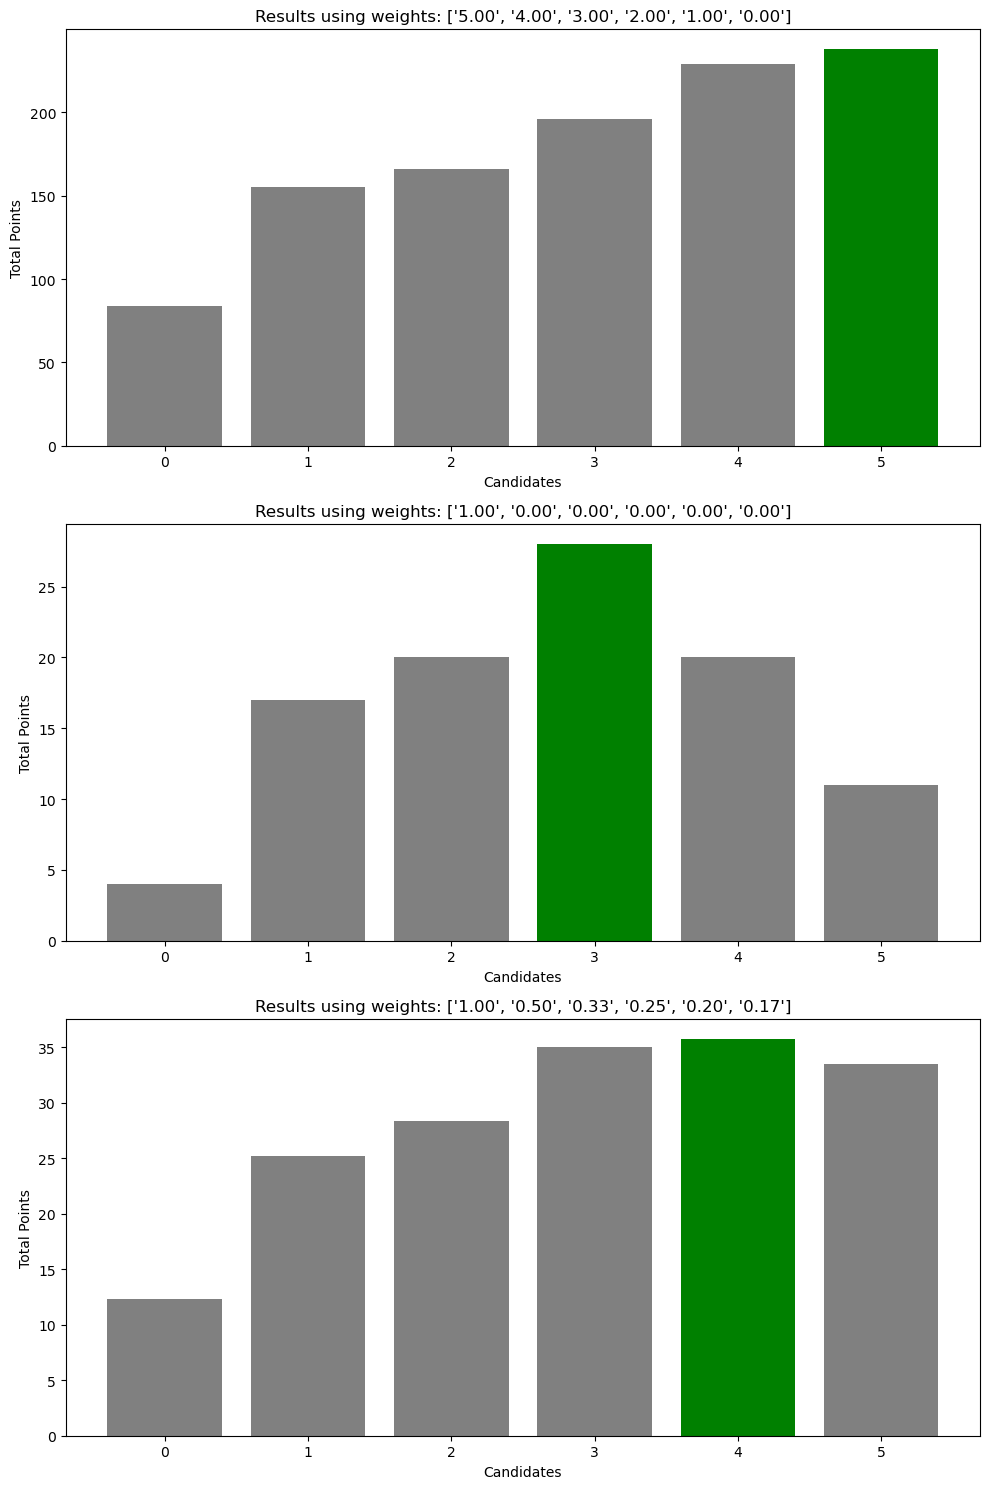

In [5]:
importlib.reload(pos);
ballots = np.loadtxt('testing/charts.txt')

# weight_sets is a list of 3 lists of weights, therefore we expect to see 3 charts
weight_sets = [[5, 4, 3, 2, 1, 0],
               [1, 0, 0, 0, 0, 0],
               [1/i for i in range(1, 7)]]
pos.display_results(ballots, weight_sets)

## Instant runoff vote

Another way to elect a candidate using ranked-choice ballots is called **instant-runoff vote**. To win, a candidate needs to be the last candidate standing after all others are eliminated.

Here is how we proceed:

1. We start by counting the **first preference** votes. This is our baseline number of votes for each candidate.
2. We then **eliminate** the **least popular candidate**, looking at the number of first preference votes.
3. We look at all the ballots which had the eliminated candidate as first preference, and **redistribute** the votes according to the **second preferences** on those ballots.
4. After eliminating one candidate and redistributing their votes to the others, we go back to step 1 until we have eliminated all candidates except one. They are the winner.

We'll break this process down into several parts.

---

### Eliminating a candidate

First, we need a way to find the least popular candidate.

#### 🚩 Task 4 [8 marks]

In `irv.py`, write a function `find_least_popular()` which takes 2 input arguments:

- `ballots`, a NumPy array containing ballot data, with one row per ballot and one column per candidate,
- `eliminated`, a list of integers (of variable length between 0 and the number of candidates minus 1) which keeps track of all candidates which have been eliminated previously,

and returns an integer between 0 and the total number of candidates minus 1, which corresponds to the index of the next candidate to eliminate.

- You may obtain up to 4 marks for this question if you assume that there will be **no ties**. To do this, your function `find_least_popular()` will only need to find which of the _remaining_ candidates has the fewest first-preference votes.
  
  
- For full marks, your function will need to be able to resolve ties, i.e. cases where 2 or more of the remaining candidates have the same smallest number of first preferences. To resolve a tie, compare the number of second preferences between the tied candidates. If there is still a tie, compare the number of third preferences; etc.

  In the (extremely unlikely!) event that there is still a tie after checking all preferences, you should eliminate the candidate with the smallest index. For example, if Candidates 2 and 5 are still tied, eliminate Candidate 2.

Resolving ties is a harder problem -- it is strongly recommended that you start with the no-ties function, continue with the rest of the assignment, and come back to this question when you are done with the rest.

_Hints:_

- You will need to use your function `tally_preferences()` to count the number of preferences for each candidate.
- You will also need to use the list `eliminated` to keep track of which candidates are no longer in the race. This is to ensure that you don't return a candidate which had already been eliminated in a previous round.
- NumPy has [useful functions](https://numpy.org/doc/stable/reference/routines.sort.html#searching) to search for particular values in arrays.

In [6]:
importlib.reload(irv);
ballots = np.loadtxt('testing/task4_notie.txt')

# First elimination should be candidate 1, then candidate 0
assert irv.find_least_popular(ballots, []) == 1
assert irv.find_least_popular(ballots, [1]) == 0
print('Tests passed for no-tie')

Tests passed for no-tie


In [7]:
importlib.reload(irv);
ballots = np.loadtxt('testing/task4_tie.txt')

# First elimination should be candidate 2, then candidate 1
assert irv.find_least_popular(ballots, []) == 2
assert irv.find_least_popular(ballots, [2]) == 1
print('Tests passed for tie')

Tests passed for tie


---

### Redistributing the votes

After a candidate is eliminated, we need to update the ballots to redistribute the votes. For brevity, let's call the currently eliminated candidate E.

- Ballots which did **not** rank E as any of their preferences are unchanged.
- Ballots which ranked E as their `n`th preference (with `n` between 1 and the total number of candidates) are updated as follows:
    - Stronger preferences (i.e. `m`th preference, where `m` < `n`) for other candidates are left unchanged.
    - The preference for E is changed from `n` to `0`.
    - Weaker preferences (i.e. `m`th preference, where `m` > `n`) for other candidates are upgraded by 1 rank.

Here is an example, with 3 ballots and 5 candidates. If Candidate 2 is eliminated, those ballots then become:

```
     before               after      
[1. 0. 0. 2. 0.]     [1. 0. 0. 2. 0.]
[1. 4. 3. 5. 2.]     [1. 3. 0. 4. 2.]
[4. 0. 1. 3. 2.]     [3. 0. 0. 2. 1.]
```

- The first ballot hadn't ranked Candidate 2 as one of their choices; it's left unchanged.
- The second ballot had ranked Candidate 2 as their third preference.
    - Since Candidate 2 is eliminated, they're now unranked.
    - Candidate 1's rank is upgraded from 4 to 3.
    - Candidate 3's rank is upgraded from 5 to 4.
    - First and second preferences are still unchanged by the elimination of Candidate 2.
- The third ballot had ranked Candidate 2 as their first preference.
    - Since Candidate 2 is eliminated, they're now unranked.
    - All other candidates which had been ranked below, are upgraded by 1 rank.

The effects of this are:

- Candidate 2 is now unranked in all ballots -- they are effectively eliminated from the competition.
- The first-preference vote in the third ballot for Candidate 2 (now eliminated) is redistributed to Candidate 4 (which was the voter's second preference) -- this is exactly what we needed.
- Preferences are still given consecutively, without gaps -- this makes it easier to deal with future eliminations.

---

#### 🚩 Task 5 [6 marks]

In `irv.py`, write a function `update_ballots()` which takes 2 input arguments:

- `ballots`, a NumPy array containing ballot data, with one row per ballot and one column per candidate,
- `to_eliminate`, an integer between 0 and the number of candidates minus 1 (inclusive), which corresponds to the candidate eliminated this round,

and returns the modified array `ballots`, where the relevant ballots have been updated as explained above.

In [10]:
importlib.reload(irv);
ballots = np.array([[1, 0, 0, 2, 0],
                    [1, 4, 3, 5, 2],
                    [4, 0, 1, 3, 2]])
expected = np.array([[1, 0, 0, 2, 0],
                     [1, 3, 0, 4, 2],
                     [3, 0, 0, 2, 1]])
updated_ballots = irv.update_ballots(ballots, 2)
np.testing.assert_equal(updated_ballots, expected)
print('Passed test.')

Passed test.


---

### Calculating the results

Now that we have our functions to find and eliminate one candidate at a time, as well as redistribute their votes, let's run the election!


---

#### 🚩 Task 6 [6 marks]

In `irv.py`, write a function `calculate_results()` which takes 1 input argument:

- `ballots`, a NumPy array containing ballot data, with one row per ballot and one column per candidate,

and returns two outputs:

- `winner`, an integer between 0 and the number of candidates minus 1 (inclusive), which corresponds to the candidate which has won the election,
- `eliminated`, a list with the same length as the number of candidates minus 1, containing integers between 0 and the number of candidates minus 1 (inclusive) corresponding to the eliminated candidates, in the order in which they were eliminated.

Your function should use `find_least_popular()` and `update_ballots()` to complete each elimination.

In [11]:
importlib.reload(irv);
ballots = np.loadtxt('testing/task6.txt')
winner, eliminated = irv.calculate_results(ballots)
assert winner == 0
assert eliminated == [2, 3, 1]
print('Passed test')

Passed test


---

## Single transferable vote

Finally, here is a more challenging problem. The **single transferable vote** system, or STV, can be seen as an extension to IRV, in the case where there are multiple seats to fill (instead of a single candidate to elect). For instance, Scottish council elections use this system to elect councillors. [This is a great explainer](https://ballotbox.scot/councils/stv-explained/), with an example from Glasgow from the 2017 local elections -- you can refer to this for a more detailed explanation.

The basic principle of votes transferring between candidates according to second preferences is broadly the same as in IRV. The key difference is that there are 2 possible situations where votes can be transferred:

- When a candidate is eliminated, their second preference votes are fully transferred to the other candidates (exactly as in IRV).
- When a candidate is _elected_, their **surplus** second preference votes are also transferred to the other candidates.

Instead of eliminating candidates until we are left with just one, we need to first check, at every round, whether any candidates are **elected**. A candidate is elected if they have at least a required quota of first-preference votes. This quota is calculated as:

$$
\text{quota} = \frac{\text{number of votes}}{\text{number of seats} + 1} + 1
$$

where we use integer division.

When a candidate is **elected**, their second preference votes are also transferred to other candidates, but with a **weighting** equal to

$$
\frac{\text{number of first preference votes} - \text{quota}}{\text{number of first preference votes}}
$$

For instance, if the quota is 100 first-preference votes to get elected, and a candidate got 120 first-preference votes, the weighting is equal to $\frac{120 - 100}{120} = 0.2$. The second-preference votes in the ballots which had placed this candidate as first preference are then redistributed amongst the other candidates, with a weighting of 0.2, meaning that each second-preference vote counts for 0.2 vote for the candidate upon which the vote has been redistributed.

When no candidates currently have enough votes to go over the quota, we revert back to eliminating the least popular candidate, following the same procedure as for IRV. This time, their second-preference votes are redistributed with a weighting of 1 to the other candidates (as in IRV).

---

#### 🚩 Task 7 [6 marks]

In `stv.py`, write a function `stv_results()` which takes 2 input arguments:

- `ballots`, a NumPy array containing ballot data, with one row per ballot and one column per candidate,
- `seats`, an integer between 1 and the number of candidates (inclusive), which corresponds to the number of seats up for election,

and returns 2 outputs:

- `elected`, a list with length `seats` containing the index of the elected candidates, in the order in which they were elected;
- `eliminated`, a list with the same length as the number of candidates minus the number of seats, containing the index of the eliminated candidates, in the order in which they were eliminated.

_Partial marks can be achieved for partially correct attempts._

In [14]:
importlib.reload(stv);

# This tests your algorithm on the same data as in the ballotbox.scot explainer.

ballots = np.loadtxt('testing/task7_glasgow.txt')
elected, eliminated = stv.stv_results(ballots, seats=4)
assert elected == [2, 3, 5, 4]
assert eliminated == [0, 1, 7, 6]
print('Passed test with Glasgow data.')

# To make sure you transfer surplus votes correctly, you can also make your function
# print out the first-preference vote tally (appropriately weighted) at every round,
# and check that you get the same numbers in each stage as on the webpage.

TypeError: 'NoneType' object is not iterable

In [15]:
importlib.reload(stv);

# This election should elect candidates 3 and 2, and eliminate candidates 0 and 1.
ballots = np.loadtxt('testing/task7_1.txt')
elected, eliminated = stv.stv_results(ballots, seats=2)
assert elected == [3, 2]
assert eliminated == [0, 1]
print('Passed test 1.')

# This election should elect candidates 2 and 1, and eliminate candidate 3.
# Candidate 0 should also be eliminated by default after candidates 2 and 1 are elected,
# as there are only 2 seats available.
ballots = np.loadtxt('testing/task7_2.txt')
elected, eliminated = stv.stv_results(ballots, seats=2)
assert elected == [1, 2]
# Pass the test whether algorithm proceeded with the final elimination,
# or stopped early as soon as 2 candidates were elected
assert eliminated in [[0], [0, 3]]
print('Passed test 2.')



TypeError: 'NoneType' object is not iterable